In [1]:
import qgrid
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import socket as socket
import os as os
import sys as sys
import multiprocessing as mp
import itertools as it
import h5py

### hapROH imports
#sys.path.insert(0,"/n/groups/reich/hringbauer/git/HAPSBURG/package/")  # hack to get development package first in path
sys.path.insert(0,"/n/groups/reich/hringbauer/git/hapBLOCK/package/hapBLOCK/IO/")  # hack to get development package first in path
from h5_load import get_coverage,get_genos_pairs,get_idx_iid,get_markers_good

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM O2 Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/hapBLOCK/"  # The Path on Harvard Cluster
else:
    raise RuntimeWarning("No compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
# Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns

print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")

sys.path.insert(0, path)

compute-a-17-74.o2.rc.hms.harvard.edu
HSM O2 Computational partition detected.
/n/groups/reich/hringbauer/git/hapBLOCK
CPU Count: 32


### Analyze the Relatedness

In [2]:
def new_column(df, df_meta, col="New Clade", col_new="", match_col="iid"):
    """Maps Entries from meta dataframe onto the IBD dataframe.
    Return modified dataframe"""
    if len(col_new)==0:
        col_new=col
    dct = pd.Series(df_meta[col].values, index=df_meta[match_col]).to_dict()
    
    for i in range(1,3):    
        df[col_new + str(i)] =df["iid" + str(i)].map(dct)
        df[col_new + str(i)] =df["iid" + str(i)].map(dct)
    return df

In [17]:
df_meta = pd.read_csv("/n/groups/reich/hringbauer/Data/v43.4.anno.csv", sep=",")  # Load Meta File

print(f"Loaded Metafile {len(df_meta)} iids")

df = pd.read_csv("./output/relatives_snp/opp_homos_ch3.tsv", sep="\t")
print(f"Loaded {len(df)} PO or identical Individuals")

df1 = new_column(df, df_meta, col='Master ID')
df1 = new_column(df, df_meta, col="n_cov_snp")
df1 = new_column(df1, df_meta, col="age")
df1 = new_column(df1, df_meta, col="study")
df1 = new_column(df1, df_meta, col="clst")
df1 = new_column(df1, df_meta, col="family")
#df1["delta_age"] = np.abs(df1["age1"] - df1["age2"])
df1['relatedness'] = "Parent Offspring"
df1.loc[df1["gt_match_rate_ch3"]>0.95, "relatedness"] = "Identical"
df1 = df1[df1["frac_snps_good_ch3"]>0.43]
len(df1)

Loaded Metafile 18171 iids
Loaded 1603 PO or identical Individuals


1593

In [ ]:
df1.sort_values(by="gt_match_rate_ch3", ascending=False)[:50]

In [112]:
df1.to_csv("./output/relatives_snp/opp_homos_ch3_processed_all.tsv", sep="\t", index=False)

# QC

In [28]:
idx_same = df1["Master ID1"] == df1["Master ID2"]
df1[idx_same]["relatedness"].value_counts()

Identical    1007
Name: relatedness, dtype: int64

In [120]:
df1["relatedness"].value_counts()

Identical           1183
Parent Offspring     410
Name: relatedness, dtype: int64

In [ ]:
df1[df1["relatedness"]=="Parent Offspring"].sort_values(by="age1")

In [ ]:
df1

# Fish out new relationships

In [35]:
idx_same = df1["Master ID1"] == df1["Master ID2"]
df2 = df1[~idx_same]
df2 = df2.sort_values(by="frac_snps_good_ch3", ascending=False)
df2=df2.drop_duplicates(subset=['Master ID1', 'Master ID2'])
df2 = df2[df2["frac_snps_good_ch3"]>0.43]
df2.to_csv("./output/relatives_snp/opp_homos_ch3_processed_uniqye.tsv", sep="\t", index=False)
len(df2)

499

## New Relationships

In [36]:
idx_new = df2["family1"].str.contains("n/a") | df2["family2"].str.contains("n/a")

In [37]:
df3=df2[idx_new]
df3 = df3[df3["frac_snps_good_ch3"]>0.43]
len(df3)

185

In [ ]:
df3.to_csv("./output/relatives_snp/opp_homos_ch3_processed_unique_novel.tsv", sep="\t", index=False)

In [ ]:
df3[df3["relatedness"]=="Parent Offspring"]

In [38]:
df3["relatedness"].value_counts()

Identical           162
Parent Offspring     23
Name: relatedness, dtype: int64

In [72]:
df_meta[df_meta["iid"].str.contains("I18945")]

,iid,Master ID,lat,lon,age,region,study,clst,mean_cov,n_cov_snp,avg_cov_snp,include_alt,family
6144,I18945,I18945,NaN,NaN,4350.0,Italy,Unpublished (Alissa broad Italian transect),Italy_Sardinia_EBA_dup.SUC009,0.702418,842902,4.818,True,n/a (no relatives detected)


In [107]:
df3[df3["study2"].str.contains("Caribbean")]

,iid1,iid2,opp_homo_rate_ch3,gt_match_rate_ch3,frac_snps_good_ch3,Master ID1,Master ID2,n_cov_snp1,n_cov_snp2,age1,age2,study1,study2,clst1,clst2,family1,family2,relatedness


In [ ]:
df3["study2"].value_counts()

In [ ]:
df3[df3["study1"].str.contains("DamgaardNature2018")]

In [ ]:
df3[np.abs(df3["age1"]-df3["age2"])>500]

# Figures

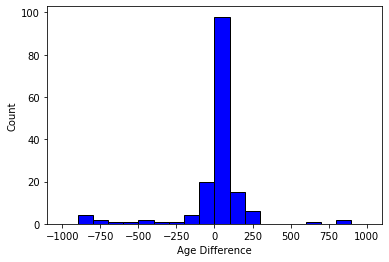

In [132]:
plt.figure()
bins=np.linspace(-1000,1000,21)
ax=plt.gca()
ax.hist(df3["age1"] - df1["age2"], ec="k", color="b", bins=bins)
ax.set_xlabel("Age Difference")
ax.set_ylabel("Count")
plt.show()

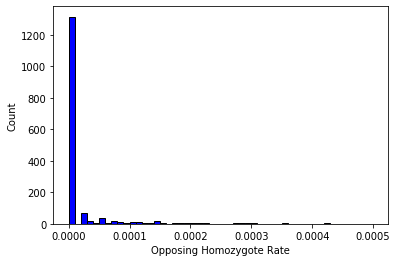

In [15]:
plt.figure()
bins=np.linspace(0,0.0005,51)
#bins=np.linspace(-500,500,21)
ax=plt.gca()
ax.hist(df1["opp_homo_rate_ch3"], ec="k", color="b", bins=bins)
ax.set_xlabel("Opposing Homozygote Rate")
ax.set_ylabel("Count")
plt.show()

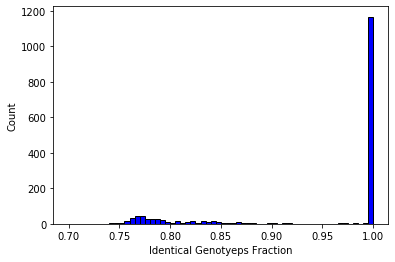

In [18]:
plt.figure()
bins=np.linspace(0.7,1.0,61)
ax=plt.gca()
ax.hist(df1["gt_match_rate_ch3"], ec="k", color="b", bins=bins)
ax.set_xlabel("Identical Genotyeps Fraction")
ax.set_ylabel("Count")
plt.show()

In [46]:
df_meta[df_meta["iid"].str.contains("prs009")]

,iid,Master ID,lat,lon,age,region,study,clst,mean_cov,n_cov_snp,avg_cov_snp,include_alt,family
3483,prs009-ALL_DATA.SG,prs008/009,54.2469,-8.55609,5380.0,Great Britain,SanchezQuintoPNAS2019,Scotland_Megalithic.SG,0.935214,1122257,3.460814,True,n/a (no relatives detected)
